In [7]:
#Importanción de librerias
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Directorio donde se encuentran las imágenes
path = 'images'

# Importar las imágenes
images = []
classNames = []
myList = os.listdir(path)

# Inicializar el detector ORB con parámetros específicos
orb = cv2.ORB_create(nfeatures=7000, scaleFactor=1.2, nlevels=15, edgeThreshold=31)

# Recorrer las imágenes en el directorio y agregarlas a la lista de imágenes
for cl in myList:
    imgCurr = cv2.imread(f'{path}/{cl}', 0)
    images.append(imgCurr)
    # Extraer el nombre del archivo sin la extensión y agregarlo a la lista de nombres de clase
    # Se crea una "clase" para cada carta para su posterior clasificación
    classNames.append(os.path.splitext(cl)[0])

In [9]:
# Función para encontrar los descriptores de las imágenes
def findDes(images):
    descList = []
    for img in images:
        # Detectar y computar los descriptores ORB de cada una de las cartas de la baraja
        kp, des = orb.detectAndCompute(img, None)
        descList.append(des)
    return descList

# Encontrar los descriptores de las imágenes
destList = findDes(images)

# Función para encontrar la identificación de una imagen de prueba
def findID(imgTest, destList, thresh=0.9):
    kp2, des2 = orb.detectAndCompute(imgTest, None)
    bf = cv2.BFMatcher()
    matchList = []
    finalVal = -1
    try:
        for des in destList:
            #Se comparan los descriptores de todas las cartas de la baraja (des) con los
            #descriptores de la imagen de prueba (des2)
            matches = bf.knnMatch(des, des2, k=2) 
            good = []
            for m, n in matches:
                # Filtrar las coincidencias con ratio de distancia
                if m.distance < 0.75 * n.distance:
                    good.append([m])
            matchList.append(len(good))
    except:
        pass

    # Encontrar la mejor coincidencia aplicando el umbral de thresh
    if len(matchList) != 0:
        if max(matchList) > thresh:
            finalVal = matchList.index(max(matchList)) #Según cambia el ID al de la carta que mayor coincidencia haya obtenido
    return finalVal

# Función para detectar cartas en una imagen
def detect_cards_in_image(image, destList):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_w, img_h = np.shape(image)[:2]
    # Determinar el nivel de fondo y el umbral de binarización
    bkg_level = img_gray[int(img_h/100)][int(img_w/2)]
    thresh_level = bkg_level + 60
    # Aplicar suavizado Gaussiano y detección de bordes Canny
    img_gaus = cv2.GaussianBlur(img_gray, (7, 7), 0)
    img_canny = cv2.Canny(img_gaus, 80, 220)

    # Encontrar contornos en la imagen binarizada
    contours, _ = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cards = []

    # Iterar sobre los contornos encontrados
    for contour in contours:
        area = cv2.contourArea(contour)
        # Filtrar los contornos basados en el área
        if area > 1000:  # Ajustamos este valor según el tamaño de las cartas en tu imagen
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            # Verificar si el contorno tiene aproximadamente cuatro esquinas
            if len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                card_roi = image[y:y+h, x:x+w]
                # Encontrar la identificación de la carta en el ROI
                card_id = findID(cv2.cvtColor(card_roi, cv2.COLOR_BGR2GRAY), destList)
                if card_id != -1:
                    cards.append((classNames[card_id], approx))
    return cards

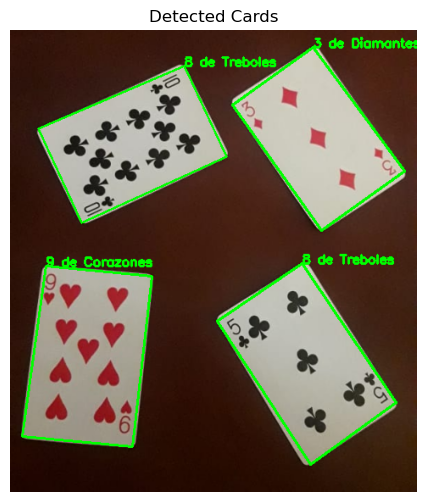

In [10]:
# Cargar la imagen de prueba
imageTest = cv2.imread('images_test/cartas.jpg')
# Detectar las cartas en la imagen
detected_cards = detect_cards_in_image(imageTest, destList)

# Dibujar contornos y etiquetas de las cartas detectadas en la imagen de prueba
for card_name, contour in detected_cards:
    cv2.drawContours(imageTest, [contour], -1, (0, 255, 0), 2)
    cv2.putText(imageTest, card_name, (contour[0][0][0], contour[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
   
# Mostrar la imagen con las cartas detectadas utilizando Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB))
plt.title('Detected Cards')
plt.axis('off')
plt.show()